In [1]:
!pip install openimages torchmetrics matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
import os
from openimages.download import download_dataset
import shutil

classes = ["Jellyfish", "Car", "Parrot"]
total_images = 350
download_dir = "./images"

if os.path.exists(download_dir):
    shutil.rmtree(download_dir)
    os.makedirs(download_dir)
else:
    os.makedirs(download_dir)

download_dataset(download_dir, classes, limit=total_images)

100%|██████████| 350/350 [00:09<00:00, 35.79it/s]


{'jellyfish': {'images_dir': './images/jellyfish/images'},
 'car': {'images_dir': './images/car/images'},
 'parrot': {'images_dir': './images/parrot/images'}}

In [20]:
if os.path.exists("./data"):
    shutil.rmtree("./data")

train_dir = "./data/train"
test_dir = "./data/test"
split_ratio = 0.8

for path in [train_dir, test_dir]:
    os.makedirs(path, exist_ok=True)

for class_name in classes:
    full_train_dir = os.path.join(train_dir, class_name.lower())
    full_test_dir = os.path.join(test_dir, class_name.lower())
    os.makedirs(full_train_dir, exist_ok=True)
    os.makedirs(full_test_dir, exist_ok=True)

    class_path = os.path.join(download_dir, class_name.lower(), "images")
    image_files = os.listdir(class_path)

    split_index = int(split_ratio * len(image_files))
    train_images = image_files[:split_index]
    test_images = image_files[split_index:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(full_train_dir, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(full_test_dir, img))

In [21]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall, F1Score
import seaborn as sns
from torch.utils.data import DataLoader
from PIL import Image

learning_rate = 1e-3

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_size, hidden_dim, second_dim):
        super(ConvolutionalNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (kanalai 16 --> 4), 3x3 branduolys
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # sutraukimo sluoksnis:
        self.pool = nn.MaxPool2d(2, 2)

        reduced_size = input_size // 4
        self.first_dim = reduced_size * reduced_size * 4

        self.fc1 = nn.Linear(self.first_dim, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, second_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.3, training=self.training)  # Dropout after activation
        x = self.fc2(x)  # Final output (raw scores)
        return x

input_size = 224
hidden_dim = 32
output_dim = len(classes) #how many classes
model = ConvolutionalNetwork(input_size, hidden_dim, output_dim)
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)


In [22]:
def train(model, loader, epoch_count=10, learning_rate=1e-3):
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    model.to(device)

    for epoch in range(epoch_count):
        loss_acc = []

        for data in loader:
            images = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_acc.append(loss.item())

        loss_sum = sum(loss_acc)

        print(f"Epoch {epoch + 1}/{epoch_count}, Loss: {loss_sum / len(loader)}")

In [26]:
def test(model, loader):
    model.eval()
    model.to(device)

    num_classes = len(loader.dataset.classes)
    class_names = loader.dataset.classes

    # Metrics
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro').to(device)
    recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro').to(device)
    f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)
    confusion = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)

    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds.cpu(), labels.cpu())
            precision.update(preds.cpu(), labels.cpu())
            recall.update(preds.cpu(), labels.cpu())
            f1.update(preds.cpu(), labels.cpu())
            confusion.update(preds.cpu(), labels.cpu())

    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1 = f1.compute()
    confusion = confusion.compute()

    # Print metrics
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall: {rec * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [24]:
train_transforms = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)

num_workers = 2
prefetch_factor = 2
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, prefetch_factor=prefetch_factor)

train(model, train_dataloader, 10, learning_rate)

Epoch 1/10, Loss: 0.8939921392334832
Epoch 2/10, Loss: 0.7064360998294972
Epoch 3/10, Loss: 0.6744996452773059
Epoch 4/10, Loss: 0.6164093735041442
Epoch 5/10, Loss: 0.5845591227213541
Epoch 6/10, Loss: 0.5913434613634039
Epoch 7/10, Loss: 0.4989883712044469
Epoch 8/10, Loss: 0.46812364679795726
Epoch 9/10, Loss: 0.4530288521890287
Epoch 10/10, Loss: 0.45071664452552795


Accuracy: 80.48%
Precision: 82.49%
Recall: 80.48%
F1 Score: 80.12%


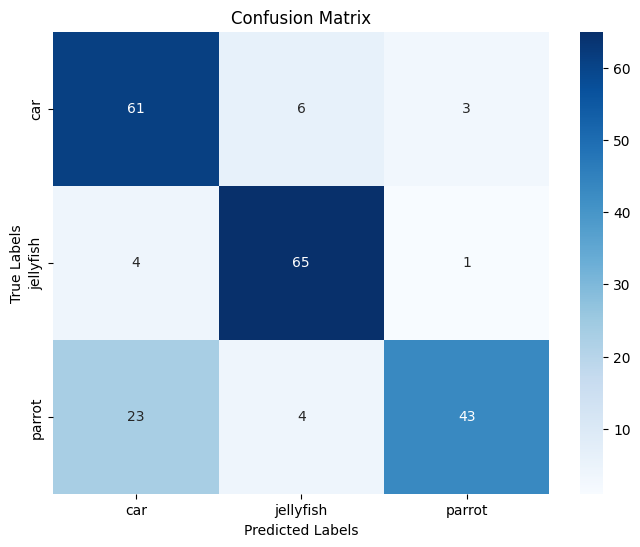

In [25]:
test_transforms = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, prefetch_factor=prefetch_factor)

test(model, test_dataloader)


save_path = './modelWeights/model_weights.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
